In [2]:
N = 3000  # number_of_columns_to_selected_in_termDocumentMatrix
target = 'insult'

In [3]:
import textmining
import nltk
import string
import numpy as np
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.feature_selection import SelectFromModel

In [4]:
data = pd.read_csv("./Dataset/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
sum(data.id.isna())

0

In [6]:
data = data.loc[:, 'id':'identity_hate']
d1 = data.loc[data[target] == 1]
d2 = data.loc[data[target] == 0]
d1.shape
d2.shape[0]
d3 = d1.append(d2[0:d1.shape[0]])
d3.shape
d3.groupby(target).size()
d3 = d3.sort_index()

data = d3.copy()
del([d1,d2,d3])

In [7]:
data.index = range(0, data.shape[0])

In [8]:
id_column = data[['id']]
id_column.shape

(15754, 1)

In [9]:
data.groupby(target).size()

insult
0    7877
1    7877
dtype: int64

# Pre-processing

In [10]:
stopwd = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [11]:
def clean(doc):
    stopwd_free = " ".join([i for i in doc.lower().split() if i not in stopwd])
    punc_free = "".join(i for i in stopwd_free if i not in punctuations)
    num_free = "".join(i for i in punc_free if not i.isdigit())
    return num_free

In [12]:
data_corpus = [clean(data.iloc[i,1]) for i in range(0, data.shape[0])]

In [13]:
data['comment_text'] = data_corpus

In [14]:
vectorizer = CountVectorizer(min_df=2, max_features=N)
vec = vectorizer.fit(data['comment_text'])

In [15]:
X = vec.transform(data['comment_text'])
X.shape

(15754, 3000)

In [16]:
train_tdm_all_features = vec.get_feature_names()           # <<=====
len(train_tdm_all_features)

3000

In [17]:
df_tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [18]:
df_tdm[target] = data[target]
df_tdm[target] = np.where(df_tdm[target] == 0.0, 0, 1)

In [19]:
df_tdm['id'] = id_column
df_tdm.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,youfuck,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting into train and test data

In [20]:
training_data = df_tdm.sample(n= int(0.8*(df_tdm.shape[0])), random_state=7)
training_data.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,youfuck,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero
7049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
index_of_training_data = training_data.index
index_of_testing_data = [index for index in df_tdm.index if index not in index_of_training_data]
test_data = df_tdm.loc[index_of_testing_data]
test_data.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,youfuck,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_tdm.groupby([target]).size()

insult
0    7877
1    7877
dtype: int64

In [23]:
training_data.groupby([target]).size()

insult
0    6290
1    6313
dtype: int64

In [24]:
test_data.groupby([target]).size()

insult
0    1587
1    1564
dtype: int64

# Creating Model

In [25]:
predictors = [x for x in df_tdm.columns if x not in [target, 'id']]
len(predictors)

2998

In [26]:
xgb_model01 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, silent=False, 
                            objective='binary:logistic', n_jobs=-1, gamma=0, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.8, seed=5)

In [27]:
xgb_params = xgb_model01.get_xgb_params()
xgtrain = xgb.DMatrix(pd.DataFrame(training_data[predictors]), label=training_data[target].values)
cvresult = xgb.cv(params=xgb_params, dtrain=xgtrain, num_boost_round=xgb_model01.get_params()['n_estimators'], nfold=5, 
                  stratified=False, folds=None, metrics='auc', obj=None, feval=None, 
                  maximize=False, early_stopping_rounds=50, verbose_eval=True)
xgb_model01.set_params(n_estimators=cvresult.shape[0])   

#Fit the xgb_model01 algorithm on the data
xgb_model01.fit(X=training_data[predictors], 
        y=training_data[target], 
        eval_metric='auc')


[0]	train-auc:0.743634+0.0128407	test-auc:0.738965+0.00974101
[1]	train-auc:0.806073+0.00983664	test-auc:0.802392+0.013346
[2]	train-auc:0.821608+0.0110884	test-auc:0.817362+0.0142986
[3]	train-auc:0.825122+0.0137039	test-auc:0.821381+0.0142935
[4]	train-auc:0.836473+0.00870553	test-auc:0.832617+0.00858993
[5]	train-auc:0.8465+0.0051803	test-auc:0.843425+0.00482214
[6]	train-auc:0.85009+0.00583139	test-auc:0.846947+0.006062
[7]	train-auc:0.857773+0.00586774	test-auc:0.854836+0.00703386
[8]	train-auc:0.862925+0.00326393	test-auc:0.859564+0.00352344
[9]	train-auc:0.86599+0.0040267	test-auc:0.861768+0.00256455
[10]	train-auc:0.866462+0.00426901	test-auc:0.862593+0.00271936
[11]	train-auc:0.866837+0.00561682	test-auc:0.863105+0.00349801
[12]	train-auc:0.873046+0.00298842	test-auc:0.867786+0.0036918
[13]	train-auc:0.875189+0.00384706	test-auc:0.87007+0.00374083
[14]	train-auc:0.878131+0.00370995	test-auc:0.872398+0.00386531
[15]	train-auc:0.881737+0.00196618	test-auc:0.875554+0.0037408
[16]

[128]	train-auc:0.963678+0.000346315	test-auc:0.947293+0.00277814
[129]	train-auc:0.963913+0.000285027	test-auc:0.94754+0.00255151
[130]	train-auc:0.964082+0.000315187	test-auc:0.947646+0.00249253
[131]	train-auc:0.964291+0.000309671	test-auc:0.947937+0.00244456
[132]	train-auc:0.964552+0.000312255	test-auc:0.948044+0.0023905
[133]	train-auc:0.964708+0.000263404	test-auc:0.948267+0.00244007
[134]	train-auc:0.964852+0.000296014	test-auc:0.948471+0.00241917
[135]	train-auc:0.965027+0.00028016	test-auc:0.948618+0.00234889
[136]	train-auc:0.965261+0.000291636	test-auc:0.948793+0.00244284
[137]	train-auc:0.965464+0.000324485	test-auc:0.948772+0.00250808
[138]	train-auc:0.965648+0.000368802	test-auc:0.948872+0.00257033
[139]	train-auc:0.965877+0.000345653	test-auc:0.94921+0.00256926
[140]	train-auc:0.965985+0.00041083	test-auc:0.949386+0.00253984
[141]	train-auc:0.96608+0.000417251	test-auc:0.94961+0.00255522
[142]	train-auc:0.966268+0.000358266	test-auc:0.949623+0.00263248
[143]	train-auc:0

[253]	train-auc:0.977334+0.000352702	test-auc:0.959224+0.00301653
[254]	train-auc:0.977396+0.000343172	test-auc:0.959319+0.0030209
[255]	train-auc:0.977451+0.000351161	test-auc:0.959296+0.00305634
[256]	train-auc:0.977517+0.000317565	test-auc:0.959311+0.00306273
[257]	train-auc:0.97755+0.000311816	test-auc:0.959378+0.00303282
[258]	train-auc:0.977602+0.00030785	test-auc:0.959439+0.00302379
[259]	train-auc:0.977672+0.00029084	test-auc:0.959475+0.00296712
[260]	train-auc:0.977719+0.000312033	test-auc:0.959551+0.00297144
[261]	train-auc:0.977765+0.000314729	test-auc:0.959595+0.00296662
[262]	train-auc:0.977814+0.000306438	test-auc:0.959633+0.00295276
[263]	train-auc:0.977853+0.000328065	test-auc:0.959686+0.00294034
[264]	train-auc:0.977897+0.000330103	test-auc:0.959702+0.00293791
[265]	train-auc:0.977947+0.00034396	test-auc:0.95975+0.00291929
[266]	train-auc:0.97801+0.000350813	test-auc:0.959818+0.00294343
[267]	train-auc:0.978079+0.00033272	test-auc:0.959938+0.00293571
[268]	train-auc:0.

[378]	train-auc:0.98233+0.000404284	test-auc:0.962872+0.00361152
[379]	train-auc:0.982367+0.00040354	test-auc:0.962866+0.00367455
[380]	train-auc:0.982405+0.00041264	test-auc:0.96288+0.0036651
[381]	train-auc:0.98244+0.000422775	test-auc:0.962959+0.00366144
[382]	train-auc:0.982468+0.00040302	test-auc:0.962979+0.00363939
[383]	train-auc:0.982497+0.000400617	test-auc:0.962998+0.00363185
[384]	train-auc:0.982509+0.000404831	test-auc:0.96301+0.00363827
[385]	train-auc:0.982532+0.000405032	test-auc:0.962995+0.00363424
[386]	train-auc:0.982559+0.000398777	test-auc:0.963058+0.0036114
[387]	train-auc:0.982581+0.00038569	test-auc:0.963003+0.00366506
[388]	train-auc:0.982609+0.000406892	test-auc:0.962985+0.00368909
[389]	train-auc:0.982644+0.000400653	test-auc:0.963004+0.00369298
[390]	train-auc:0.98267+0.00039874	test-auc:0.963033+0.00370873
[391]	train-auc:0.982702+0.000398012	test-auc:0.963042+0.00375138
[392]	train-auc:0.982732+0.000407982	test-auc:0.963048+0.00374523
[393]	train-auc:0.9827

[504]	train-auc:0.985204+0.000340878	test-auc:0.96406+0.00384921
[505]	train-auc:0.98522+0.000343957	test-auc:0.964099+0.00382457
[506]	train-auc:0.985227+0.000339589	test-auc:0.964125+0.00383438
[507]	train-auc:0.985241+0.000348335	test-auc:0.964127+0.00383557
[508]	train-auc:0.985266+0.000339119	test-auc:0.964162+0.00384045
[509]	train-auc:0.985276+0.000353449	test-auc:0.964175+0.0038326
[510]	train-auc:0.985283+0.000351808	test-auc:0.964182+0.00382408
[511]	train-auc:0.985304+0.000352623	test-auc:0.964178+0.00383104
[512]	train-auc:0.985315+0.000352805	test-auc:0.96419+0.0038346
[513]	train-auc:0.985325+0.0003585	test-auc:0.964215+0.00385378
[514]	train-auc:0.98535+0.000373458	test-auc:0.964233+0.00385061
[515]	train-auc:0.985367+0.000377243	test-auc:0.964269+0.00386066
[516]	train-auc:0.985391+0.000375769	test-auc:0.964281+0.00386306
[517]	train-auc:0.985418+0.000379387	test-auc:0.964278+0.00386462
[518]	train-auc:0.985427+0.000382692	test-auc:0.964266+0.00386941
[519]	train-auc:0.

[629]	train-auc:0.987046+0.000337877	test-auc:0.96486+0.00394446
[630]	train-auc:0.987067+0.000339249	test-auc:0.964878+0.00395809
[631]	train-auc:0.98708+0.000344975	test-auc:0.964862+0.00398748
[632]	train-auc:0.98709+0.000346619	test-auc:0.964863+0.00397047
[633]	train-auc:0.987099+0.000349089	test-auc:0.964868+0.00398278
[634]	train-auc:0.987103+0.000351116	test-auc:0.964856+0.0039923
[635]	train-auc:0.987119+0.000350255	test-auc:0.964836+0.00398212
[636]	train-auc:0.987131+0.000348657	test-auc:0.964834+0.00400379
[637]	train-auc:0.987138+0.000352891	test-auc:0.96488+0.00397976
[638]	train-auc:0.987147+0.000351475	test-auc:0.964892+0.00397829
[639]	train-auc:0.987156+0.000355267	test-auc:0.964902+0.00397719
[640]	train-auc:0.987176+0.000347901	test-auc:0.964889+0.00400411
[641]	train-auc:0.987182+0.000347194	test-auc:0.964882+0.00399159
[642]	train-auc:0.987198+0.000352067	test-auc:0.964875+0.00401415
[643]	train-auc:0.987211+0.000346054	test-auc:0.964865+0.00401632
[644]	train-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=658,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=5, silent=False, subsample=0.8)

###### Feature Importance Graph

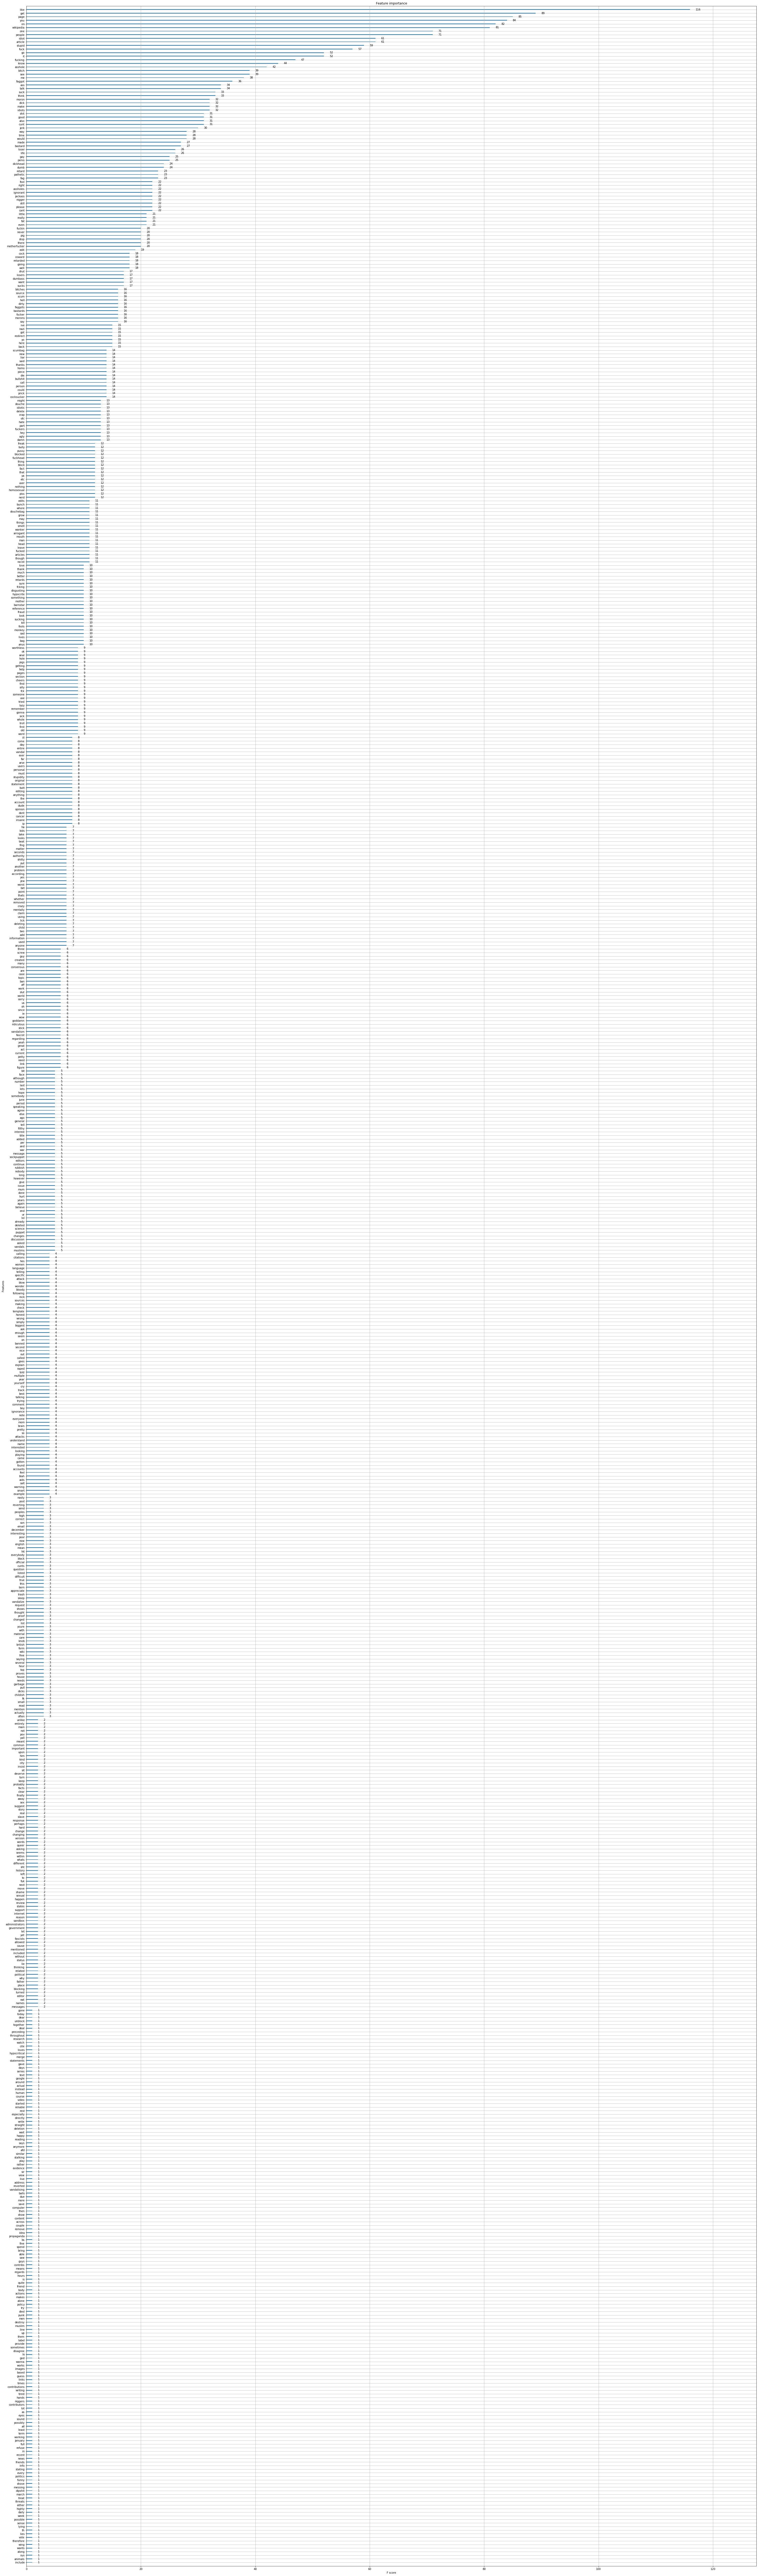

In [28]:
rcParams['figure.figsize'] = 50,180
xgb.plot_importance(xgb_model01.get_booster())

In [29]:
#Predict training set:
train_predictions = xgb_model01.predict(training_data[predictors])
train_predprob = xgb_model01.predict_proba(training_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(training_data[target], train_predictions)) * 100
AUC = float(roc_auc_score(training_data[target], train_predprob, average='weighted')) * 100
f1 = float(f1_score(training_data[target], train_predictions, average='weighted')) * 100

print("\nModel Report (TRAIN) :\n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

# Predicting on test data:
test_predictions = xgb_model01.predict(test_data[predictors])
test_predprob = xgb_model01.predict_proba(test_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(test_data[target], test_predictions)) * 100
AUC = float(roc_auc_score(test_data[target], test_predprob, average='weighted')) * 100
f1 = float(f1_score(test_data[target], test_predictions, average='weighted')) * 100

print("\nModel Report (TEST) : \n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TRAIN) :

Accurary : 94.2236
AUC Score : 98.6773
F1 Score : 94.2193


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TEST) : 

Accurary : 90.7648
AUC Score : 96.4612
F1 Score : 90.7427


# Saving Model

In [32]:
path = './model pickle/'
filename = path + "XGBClassifier_equalData_" + target + "_" + str(N) + "_F1_Score" + str(format(f1, '.6g'))
joblib.dump(xgb_model01, filename)

['./model pickle/XGBClassifier_equalData_insult_3000_F1_Score90.7427']

# Loading Model

In [32]:
# path = './model pickle/'
# filename = path + 'XGBClassifier_equalData_toxic_3000_F1_Score87.6949'
# xgb_model01 = joblib.load(filename)

# Probability prediction for test.csv provided by kaggle

In [33]:
testCSV = pd.read_csv('./Dataset/test.csv')

In [34]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [35]:
testCSV.shape

(153164, 2)

### Pre-processing

In [36]:
data_corpus_testCSV = [clean(testCSV.iloc[i,1]) for i in range(0, testCSV.shape[0])]

In [37]:
testCSV['comment_text'] = data_corpus_testCSV

In [38]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine is imo
2,00013b17ad220c46,sources zawe ashton lapland —
3,00017563c3f7919a,if look back source information updated correc...
4,00017695ad8997eb,anonymously edit articles all


In [42]:
vectorizer = CountVectorizer(min_df=2, max_features=N, vocabulary=train_tdm_all_features) 
vec = vectorizer.fit(testCSV['comment_text'])

In [43]:
X = vec.transform(testCSV['comment_text'])
X.shape

(153164, 3000)

In [44]:
df_tdm_testCSV = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [45]:
df_tdm_testCSV.id = testCSV.id

In [46]:
predictors_for_testCSV = [x for x in df_tdm_testCSV.columns if x not in [target, 'id']]

In [47]:
df_tdm_testCSV[predictors_for_testCSV].shape

(153164, 2998)

In [48]:
df_tdm_testCSV.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,youfuck,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
prediction_final = xgb_model01.predict_proba((df_tdm_testCSV[predictors_for_testCSV]))[:,1]

In [50]:
final_submission = pd.read_csv('./sample_submission.csv')

In [51]:
final_submission[target] = prediction_final

In [52]:
final_submission.head()

,Unnamed: 0,id,toxic,severe_toxic,obscene,threat,insult
0,0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933108,0.999919
1,1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509,0.188381
2,2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009,0.254462
3,3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236,0.032124
4,4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571,0.218125


In [53]:
final_submission = final_submission.drop(['Unnamed: 0'], axis=1)

In [54]:
final_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult
0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933108,0.999919
1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509,0.188381
2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009,0.254462
3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236,0.032124
4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571,0.218125


###### Saving csv file on the disk

In [57]:
final_submission.to_csv('./sample_submission.csv')